# Portfolio Optimization with stocks, bonds and commodities

An application of Modern Portfolio Theory (MPT) is presented with the extra twist that (risky) portfolio performance is optimized for several asset classes instead of just stocks. The overall optimal portfolio, a combination of the optimal risky portfolio with the risk-free, is also calculated using the investor's risk aversion.

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import scipy.optimize as sco
import investpy
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib as mpl


First, we complete an online questionnaire to ascertain our risk aversion. Such questionnaires provide a suggested allocation to stocks and bonds. Some even extend their analysis to commodities. After we select the allocation of assets we select our instruments. We have opted for 6 stocks, 2 bonds and 2 commodities for a total of 10 assets. The selection of each asset is up to the investor. Here, the focus is on diversification and the analysis spans the last five years.

# Asset Allocation and Security Selection

In [2]:
# portfolio allocation for stocks, bonds and commodities respectively
ss, bb, cc = 0.7, 0.2, 0.1

# instrument selection
stocks = ['AVGO','NOW', 'TSLA', 'AMZN', 'IRDM', 'BR']
bonds = ['PYACX', 'SIGAX']
commodities = ['gold','palladium']

rf = 2.27
sp500 = ['S&P 500']

assets = stocks + bonds + commodities + sp500
print(assets)

['AVGO', 'NOW', 'TSLA', 'AMZN', 'IRDM', 'BR', 'PYACX', 'SIGAX', 'gold', 'palladium', 'S&P 500']


We proceed to get the historical data for the selected securities. `InvestPy` provides the necessary data extraction tools. The `yfinance` is a great alternative, but does not support commodities. Unfortunately, `investPy` cannot extract the historical data all at once (like `yfinance`) and we have to endure the following arduous data extraction:

In [3]:
d = datetime.datetime(2020, 1, 13) - relativedelta(years=5)
from_date = str(d.day) + '/' + str(d.month) + '/' + str(d.year)

d = datetime.datetime(2020, 1, 13)
to_date = str(d.day) + '/' + str(d.month) + '/' + str(d.year)

s1 = investpy.stocks.get_stock_historical_data(stock=stocks[0], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s2 = investpy.stocks.get_stock_historical_data(stock=stocks[1], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s3 = investpy.stocks.get_stock_historical_data(stock=stocks[2], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s4 = investpy.stocks.get_stock_historical_data(stock=stocks[3], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s5 = investpy.stocks.get_stock_historical_data(stock=stocks[4], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s6 = investpy.stocks.get_stock_historical_data(stock=stocks[5], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

b1 = investpy.funds.get_fund_historical_data(fund='Payden Corporate Bond Fund', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
b2 = investpy.funds.get_fund_historical_data(fund='Western Asset Corporate Bond Fund Class A', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

c1 = investpy.commodities.get_commodity_historical_data(commodity=commodities[0],from_date=from_date, to_date=to_date, interval='Daily')['Close']
c2 = investpy.commodities.get_commodity_historical_data(commodity=commodities[1],from_date=from_date, to_date=to_date, interval='Daily')['Close']

benchmark = investpy.indices.get_index_historical_data(index='S&P 500', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

Finally, we concatenate all the panda Series to a single Dataframe for ease of use. We plot the historical prices for all assets.

In [4]:
# Place the DataFrames side by side
data = pd.concat([s1, s2, s3, s4, s5, s6, b1, b2, c1, c2, benchmark], axis = 1)
data.columns = assets
data = data.dropna()
data.head()

,AVGO,NOW,TSLA,AMZN,IRDM,BR,PYACX,SIGAX,gold,palladium,S&P 500
Date,,,,,,,,,,,
2015-01-13,102.58,67.27,204.25,294.74,9.32,46.78,11.22,12.46,1234.3,815.70,2023.03
2015-01-14,103.39,66.34,192.69,293.27,9.12,46.39,11.23,12.45,1234.4,780.65,2011.27
2015-01-15,101.32,63.63,191.87,286.95,8.63,45.94,11.27,12.46,1264.7,766.35,1992.67
2015-01-16,103.82,63.96,193.07,290.74,8.84,46.76,11.23,12.43,1276.9,754.30,2019.42
2015-01-20,104.87,64.83,191.93,289.44,9.11,46.50,11.26,12.45,1294.2,778.75,2022.55


Text(0, 0.5, 'Daily Prices ($)')

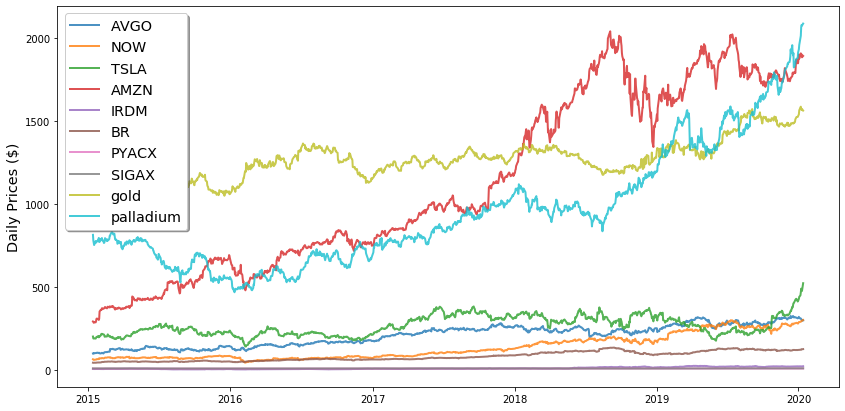

In [5]:
# plot historical prices for all assets
plt.figure(figsize=(14, 7))
for c in data.columns[:-1].values:
    plt.plot(data.index, data[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize='x-large',shadow=True)
plt.ylabel('Daily Prices ($)', fontsize='x-large')

Another visualization is presented below.

Text(0.5, 1.0, '"Yahoo-Finance style" price plot')

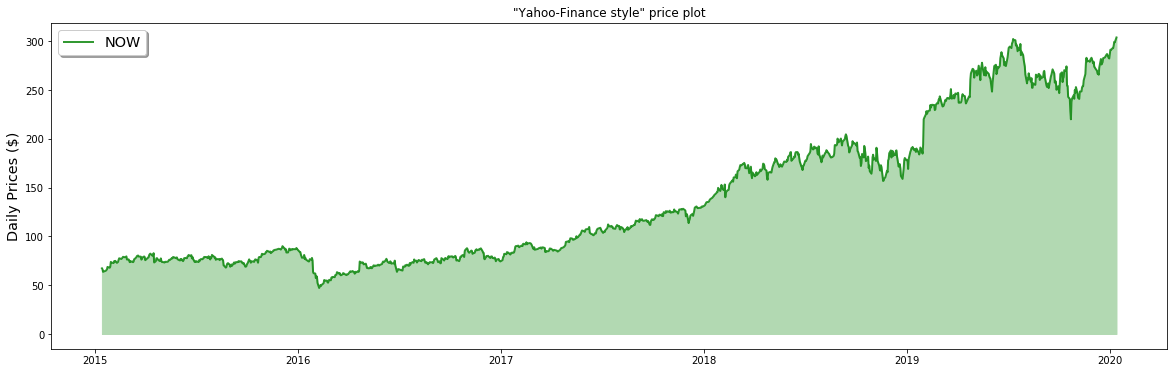

In [6]:
# "Yahoo-Finance style" plot 
sec = 'NOW'
mix=0.7
primary_color = 'green'
plt.figure(figsize=(20,6))
plt.plot(data[sec], lw=2, alpha=0.8,label=sec,color=primary_color)
plt.legend(loc='upper left', fontsize='x-large',shadow=True)
c1=np.array(mpl.colors.to_rgb(primary_color))
c2=np.array(mpl.colors.to_rgb('white'))
plt.fill_between(data[sec].index, data[sec].values,color=mpl.colors.to_hex((1-mix)*c1 + mix*c2))
plt.ylabel('Daily Prices ($)', fontsize='x-large')
plt.title('"Yahoo-Finance style" price plot')

The historical prices on their own are not useful. We calculate the daily returns.

In [7]:
daily_returns = data.pct_change()[1:]*100

print(daily_returns)

                AVGO       NOW      TSLA      AMZN      IRDM        BR  \
Date                                                                     
2015-01-14  0.789628 -1.382488 -5.659731 -0.498745 -2.145923 -0.833690   
2015-01-15 -2.002128 -4.085017 -0.425554 -2.155011 -5.372807 -0.970037   
2015-01-16  2.467430  0.518623  0.625423  1.320788  2.433372  1.784937   
2015-01-20  1.011366  1.360225 -0.590459 -0.447135  3.054299 -0.556031   
2015-01-21  0.486316  1.064322  2.417548  2.698314  0.000000  0.107527   
...              ...       ...       ...       ...       ...       ...   
2020-01-07 -0.344256  0.013658  3.880055  0.209157 -1.797125 -0.352000   
2020-01-08 -1.247441  0.935441  4.920479 -0.780865 -0.366002  0.642261   
2020-01-09 -0.803265  1.237950 -2.194498  0.479923  1.469388  2.185705   
2020-01-10 -2.298700 -0.143664 -0.662733 -0.941059 -0.040225 -0.398126   
2020-01-13  0.655036  1.662875  9.768901  0.432252  2.575453  0.705384   

               PYACX     SIGAX      g

# Financial Measures

Descriptive statistics are broken down into measures of central tendency and measures of variability (spread). Measures of central tendency include the mean, median, and mode, while measures of variability include the standard deviation, variance, the minimum and maximum variables, and the kurtosis and skewness.

![](../report/media/descriptive_statistics.png)

We also calculate important financial measures such as Jensen's alpha, beta and R-squared.

In [8]:
measures = ['mean (%)','median (%)','std (%)','var (%)','min (%)','max (%)','kurtosis','skewness', 'alpha','beta','R-squared']
df = pd.DataFrame(columns=measures, index=assets)

In [35]:
import statistics
import scipy.stats

x = daily_returns[assets[-1]].values
rf_daily = (np.power((1+(rf/100)),(1/252)) - 1) * 100
x = x - rf_daily

for i in range(len(assets)):
    # fetch returns for asset i
    l = daily_returns[assets[i]].tolist()
    # compute descriptive statistics for instrument i
    df.iloc[i]['mean (%)'] = statistics.mean(l)
    df.iloc[i]['median (%)'] = statistics.median(l)
    df.iloc[i]['std (%)'] = statistics.stdev(l)
    df.iloc[i]['var (%)'] = statistics.variance(l)
    df.iloc[i]['min (%)'] = min(l)
    df.iloc[i]['max (%)'] = max(l)
    df.iloc[i]['kurtosis'] = scipy.stats.kurtosis(l)
    df.iloc[i]['skewness'] = scipy.stats.skew(l)
    
    y = daily_returns[assets[i]].values - rf_daily
    
    # compute alpha, beta, r-squared for instrument i
    (beta, alpha, r_value) = scipy.stats.linregress(x,y)[0:3]
    df.iloc[i]['alpha'] = (np.power((1 + (alpha/100)), 252) - 1)
    df.iloc[i]['beta'] = beta
    df.iloc[i]['R-squared'] = r_value ** 2


,mean (%),median (%),std (%),var (%),min (%),max (%),kurtosis,skewness
AVGO,0.107166,0.111262,2.04098,4.1656,-13.7447,14.7054,5.30694,0.234287
NOW,0.145902,0.206555,2.22672,4.95827,-15.6561,14.0685,6.50428,-0.331896
TSLA,0.116156,0.0604412,2.85081,8.1271,-13.9015,17.6692,5.06032,0.302733
AMZN,0.166039,0.137357,1.84799,3.41508,-7.81968,14.1311,9.82735,1.00681
IRDM,0.115048,0.118483,2.6336,6.93584,-11.1297,22.2393,6.47356,0.623741
BR,0.0891013,0.0910391,1.26773,1.60714,-9.70149,11.1618,9.28693,-0.187851
PYACX,0.00433104,0,0.267192,0.0713917,-2.07769,0.771208,3.40086,-0.708179
SIGAX,0.00341559,0,0.228246,0.0520964,-1.28928,0.668338,1.28455,-0.434499
gold,0.0237899,0,0.988315,0.976766,-4.31929,5.09752,4.5533,0.328708
palladium,0.089933,0.150464,1.70887,2.92022,-7.40462,7.28252,1.49086,-0.147156


In [36]:
# print the descriptive statistics
df.iloc[:,:8]

,mean (%),median (%),std (%),var (%),min (%),max (%),kurtosis,skewness
AVGO,0.107166,0.111262,2.04098,4.1656,-13.7447,14.7054,5.30694,0.234287
NOW,0.145902,0.206555,2.22672,4.95827,-15.6561,14.0685,6.50428,-0.331896
TSLA,0.116156,0.0604412,2.85081,8.1271,-13.9015,17.6692,5.06032,0.302733
AMZN,0.166039,0.137357,1.84799,3.41508,-7.81968,14.1311,9.82735,1.00681
IRDM,0.115048,0.118483,2.6336,6.93584,-11.1297,22.2393,6.47356,0.623741
BR,0.0891013,0.0910391,1.26773,1.60714,-9.70149,11.1618,9.28693,-0.187851
PYACX,0.00433104,0,0.267192,0.0713917,-2.07769,0.771208,3.40086,-0.708179
SIGAX,0.00341559,0,0.228246,0.0520964,-1.28928,0.668338,1.28455,-0.434499
gold,0.0237899,0,0.988315,0.976766,-4.31929,5.09752,4.5533,0.328708
palladium,0.089933,0.150464,1.70887,2.92022,-7.40462,7.28252,1.49086,-0.147156


In [37]:
# print the othe financial measures
df.iloc[:,8:]

,alpha,beta,R-squared
AVGO,0.142129,1.35333,0.313931
NOW,0.247185,1.46614,0.309546
TSLA,0.177113,1.26445,0.140465
AMZN,0.328149,1.32199,0.365389
IRDM,0.15867,1.41795,0.206979
BR,0.132064,0.920635,0.376552
PYACX,-0.00576098,-0.0679181,0.0461344
SIGAX,-0.0121462,-0.0191122,0.00500632
gold,0.0516155,-0.151393,0.0167542
palladium,0.178173,0.47398,0.0549296


## Correlation Matrix

(11.5, -0.5)

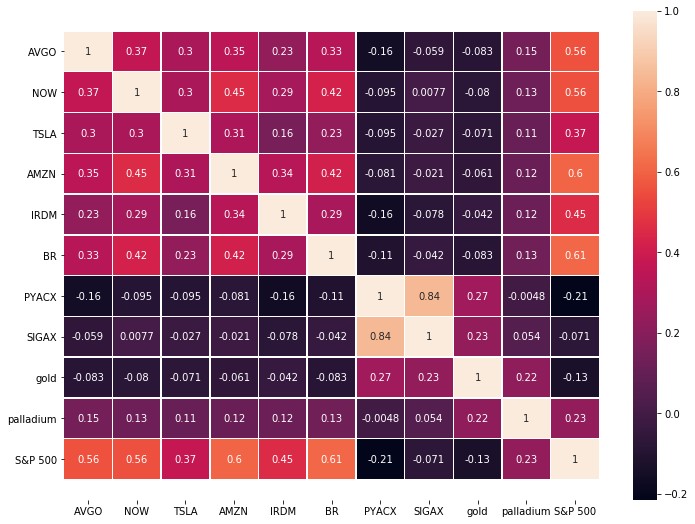

In [10]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(daily_returns.corr(), annot=True,  linewidths=.5, ax=ax)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Risk and Return

We calculate the annualised returns for the selected assets. We then proceed to build a naive portfolio where the allocation is divided equally between assets of the same asset class, i.e. stocks, bonds and commodities. This naive portfolio will be useful as a baseline and we will be able to appreciate the benefits of portfolio optimization.

In [11]:
# discard the benchmark (S&P500)
selected = assets[:-1]
table = data[assets[:-1]]

# calculate daily and annual returns of the assets
returns_daily = data[assets[:-1]].pct_change()[1:] * 100
returns_annual = (np.power((1 + (returns_daily.mean()/100)), 252) - 1) * 100

# get daily covariance of returns of the stock
cov_daily = (returns_daily/100).cov()

# Calculate Risk/Return of a naive portfolio
# allocation is divided equally between assets of the same asset class,
# i.e. stocks, bonds and commodities
s = [ss/len(stocks) for _ in range(len(stocks))]
b = [bb/len(bonds) for _ in range(len(bonds))]
c = [cc/len(commodities) for _ in range(len(commodities))]
weights =  np.hstack((s,b,c))
weights_naive = weights / np.sum(weights)


returns_naive = np.dot(weights_naive, returns_annual)
volatility_naive = np.sqrt(np.dot(weights_naive.T, np.dot(cov_daily, weights_naive))) * np.sqrt(252) * 100
# the beta of the overall portfolio is the weighted average of the associated assets
beta_naive = np.dot(weights_naive, df['beta'].to_numpy()[:-1])
sharpe_naive = (returns_naive - rf)/(volatility_naive)

# print results
print(f'The return of the naive portfolio is {returns_naive:.2f}%')
print(f'The risk of the naive portfolio is {volatility_naive:.2f}%')
print(f'The beta of the naive portfolio is {beta_naive:.2f}')
print(f'The Sharpe Ratio of the naive portfolio is {sharpe_naive:.2f}')

The return of the naive portfolio is 27.45%
The risk of the naive portfolio is 15.76%
The beta of the naive portfolio is 0.91
The Sharpe Ratio of the naive portfolio is 1.60


# Optimal Portfolio

## Simulation
We repeat the same process for $n=200000$ random portfolios. The weight allocation is subject to the constraints imposed by the questionnaire.

In [12]:
# produce random weight vector with stock/bond/commodity fixed allocation
def random_weights():
    s = np.random.random(len(stocks))
    s = s / np.sum(s)
    s = ss * s
    b = np.random.random(len(bonds))
    b = b / np.sum(b)
    b = bb * b
    c = np.random.random(len(commodities))
    c = c / np.sum(c)
    c = cc * c
    weights =  np.hstack((s,b,c))
    return weights

In [25]:
# empty lists to store returns, volatility and weights of imaginary portfolios
port_returns = []
port_volatility = []
port_sharpe_ratio = []
port_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 200000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = random_weights()
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights))) * np.sqrt(252) * 100
    
    # store the return, volatility, Sharpe ratio and weights for this imaginary portfolio
    port_returns.append(returns)
    port_sharpe_ratio.append((returns - rf)/volatility)
    port_volatility.append(volatility)
    port_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': port_sharpe_ratio
            }

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in port_weights]

# make a nice dataframe of the extended dictionary
df_ef = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility','Sharpe Ratio'] + [asset+' Weight' for asset in selected]

# reorder dataframe columns
df_ef = df_ef[column_order]

# show the dataframe
df_ef.head().T

,0,1,2,3,4
Returns,27.564982,25.832930,29.483031,27.194185,28.729720
Volatility,18.601996,16.655053,16.543772,19.358995,14.661918
Sharpe Ratio,1.359799,1.414762,1.644911,1.287473,1.804656
AVGO Weight,0.173061,0.043227,0.103413,0.141240,0.103763
NOW Weight,0.049834,0.120769,0.013696,0.165687,0.037714
TSLA Weight,0.224644,0.235619,0.091120,0.055217,0.049232
AMZN Weight,0.082006,0.080768,0.261672,0.012694,0.265705
IRDM Weight,0.161158,0.014101,0.170300,0.316699,0.009366
BR Weight,0.009297,0.205516,0.059798,0.008463,0.234219
PYACX Weight,0.097707,0.156779,0.116514,0.148173,0.148747


By this simulation we have a pretty good idea of the optimal portfolio; we simply find the portfolio with the maximum Sharpe ratio. As we will see, we are able to do even better by formulating an optimization problem. For now, let's visualize the results!

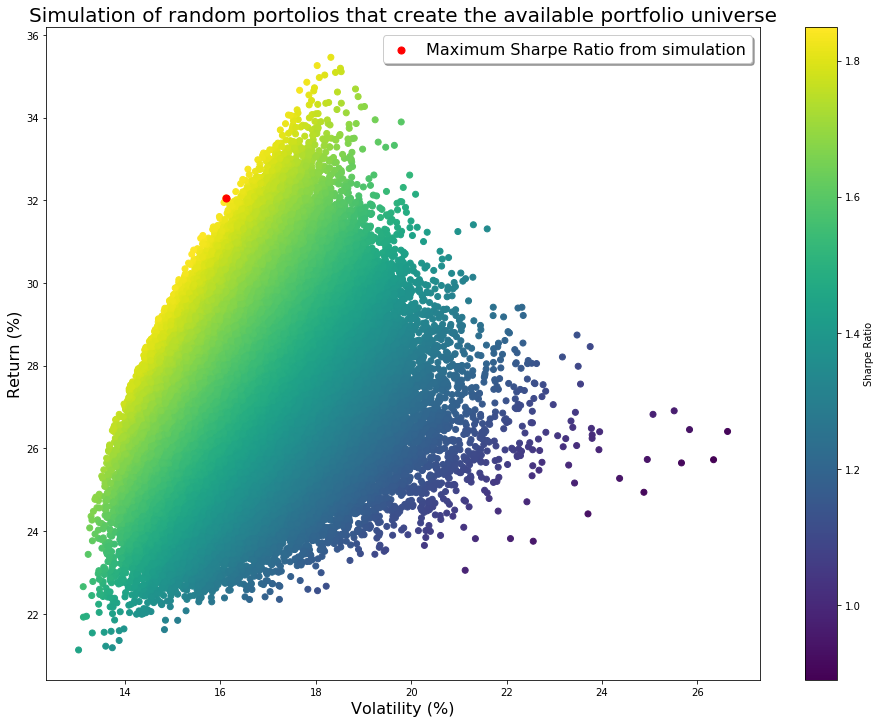

In [14]:
# the optimal risky portfolio has the highest Sharpe Ratio
id = df_ef['Sharpe Ratio'].idxmax()
max_sr_vol, max_sr_ret = df_ef['Volatility'][id], df_ef['Returns'][id]

max_sr = df_ef['Sharpe Ratio'].max()
optimal_weights = port_weights[id]

fig, ax = plt.subplots(figsize=(16, 12))

plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50, label='Maximum Sharpe Ratio from simulation') # red dot

ax.set_title('Simulation of random portolios that create the available portfolio universe', fontsize=20)
ax.set_xlabel('Volatility (%)', fontsize=16)
ax.set_ylabel('Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

In [15]:
print(f'The Sharpe ratio of the optimal portfolio via simulation is {max_sr} and the respective allocation is \n {optimal_weights*100}')

The Sharpe ratio of the optimal portfolio via simulation is 1.8486159423765698 and the respective allocation is 
 [ 1.1213237   5.25627229  1.63866197 39.86840827  1.0207762  21.09455757
  7.50703211 12.49296789  1.33880214  8.66119786]


## Efficient Frontier

From Investopedia, "the efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return". 

To plot the Efficient Frontier, an array of optimization problems must be solved. To be more specific, a point on the Efficient frontier has the lowest possible risk for a given return. Thus, the associated optimization problem is:
$$
\begin{align*}
\text{min }\quad & \sqrt{\vec{w}^\top K  \vec{w} }\\
\text{s.t. }\quad & \mathbf{ 1 }^\top \vec{w}=1 \\
& \vec { w }^\top \mathbb{E} (\mathcal{R}) = r \\
& \mathbf{ 1 }^\top \vec{w}_{\mathcal{ S } } = w_s \\
& \mathbf{ 1 }^\top \vec{w}_{\mathcal{ B } } = w_b \\
& \mathbf{ 1 }^\top \vec{w}_{\mathcal{ C } } = w_c \\
& w_s + w_b + w_c = 1 \\
& w_i \geq 0 \quad i=1,\dots,n
\end{align*}
$$
where $\vec{w}$ is the weight vector associated with the $n$ assets, $\vec{w}_{\mathcal{ S } }$, $\vec{w}_{\mathcal{ B } }$ and $\vec{w}_{\mathcal{ C } }$ are the weights associated with the stock, bond and commodity assets and sum up to $w_s$, $w_b$ and $w_c$, respectively. Obviously, the concatenation of these vectors is the original weight vector, i.e. $\mathcal{ S } \sqcup \mathcal{ B } \sqcup \mathcal{ C } =\{1,\cdots,n\}$. In other words, the objective corresponds to the minimization of the portfolio's standard deviation, i.e. risk, and the constraints construct the feasibility region of the optimization problem given the demands dictated by the suggested allocation resulting in the weights $w_s$, $w_b$ and $w_c$ given the portfolio's fixed return.


In [16]:
# the objective function corresponds to the (annualized) risk
def portfolio_volatility(weights, cov_daily):
    return (np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights))) * np.sqrt(252) * 100)

def efficient_return(returns_annual, cov_daily, target):
    num_assets = len(returns_annual)
    args = (cov_daily)

    def portfolio_return(weights):
        return np.dot(weights, returns_annual)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[:len(stocks)]) - ss},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[-len(commodities):]) - cc}
                  )
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(returns_annual, cov_daily, returns_range):
    return [efficient_return(returns_annual, cov_daily, ret) for ret in returns_range]

Using the simulation, we are able to have a very accurate idea of the minimum and maximum returns of the possible random portfolios. By minimizing the risk in that interval we get the Efficient Frontier.

In [17]:
# Find the EF
targets = np.linspace(df_ef['Returns'].min(), df_ef['Returns'].max(), 1000)
efficient_portfolios = efficient_frontier(returns_annual, cov_daily, targets)

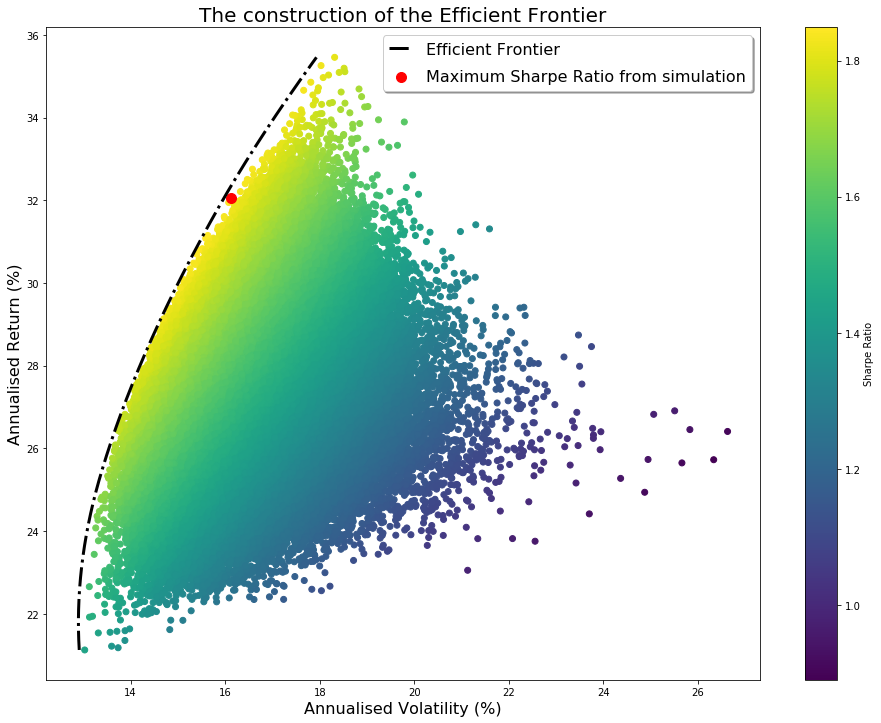

In [18]:
# Graph that includes:
#     1. the Random Portfolios
#     2. The Efficient Frontier
#     3. The Optimal Risky Portfolio from Simulation
fig, ax = plt.subplots(figsize=(16, 12))

# plot (1) the Random Portfolios
plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
cbar = plt.colorbar(label='Sharpe Ratio')

# plot (2) The Efficient Frontier
ax.plot([p['fun'] for p in efficient_portfolios], targets, linestyle='-.',lw=3, color='black', label='Efficient Frontier')

# plot (3) the Optimal Risky Portfolio from Simulation
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100, label='Maximum Sharpe Ratio from simulation') 

# title, axes and legend
ax.set_title('The construction of the Efficient Frontier', fontsize=20)
ax.set_xlabel('Annualised Volatility (%)', fontsize=16)
ax.set_ylabel('Annualised Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

## Portfolio Optimization


In order to find the optimal portfolio, we ought to solve the following optimization problem:
$$
\begin{align*}
\text{max }\quad & \frac{\vec{w}^\top\cdot \mathbb{E} (\mathcal{R}) -r_f}{\sqrt{\vec{w}^\top K  \vec{w} }}\\
\text{s.t. }\quad & \mathbf{ 1 }^\top \vec{w}=1 \\
& \mathbf{ 1 }^\top \vec{w}_{\mathcal{ S } } = w_s \\
& \mathbf{ 1 }^\top \vec{w}_{\mathcal{ B } } = w_b \\
& \mathbf{ 1 }^\top \vec{w}_{\mathcal{ C } } = w_c \\
& w_s + w_b + w_c = 1 \\
& w_i \geq 0 \quad i=1,\dots,n
\end{align*}
$$
Thus, the objective corresponds to the Sharpe Ratio and the constraints construct the feasibility region of the optimization problem given the demands dictated by the suggested allocation resulting in the weights $w_s$, $w_b$ and $w_c$.

In [19]:
def max_sr(weights, returns_annual, cov_daily, rf):
    return -(np.dot(weights, returns_annual) - rf)/(np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights))) * np.sqrt(252) * 100)

def optimal_point(returns_annual, cov_daily, rf):
    num_assets = len(returns_annual)
    args = (returns_annual, cov_daily, rf)

    def portfolio_return(weights):
        return np.dot(weights, returns_annual)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[:len(stocks)]) - ss},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[-len(commodities):]) - cc}
                  )
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(max_sr, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Finally we have the optimal risky portfolio! Let's plot the results!

In [20]:
#Find the optimal sharpe ratio of the EF
optimal_sharpe_ratio = optimal_point(returns_annual, cov_daily, rf)

opt_sharpe = -optimal_sharpe_ratio['fun']
opt_weights = optimal_sharpe_ratio['x']
opt_vol = np.sqrt(np.dot(opt_weights.T, np.dot(cov_daily, opt_weights))) * np.sqrt(252) * 100
opt_ret = np.dot(opt_weights, returns_annual)

print(f'The optimal portfolio has a return of {opt_ret:.2f}% with a standard deviation of {opt_vol:.2f}% yielding a Shapre Ratio equal to {opt_sharpe:.2f}.')
print(f'The optimal weights are {(opt_weights*100).round(2)}')

The optimal portfolio has a return of 32.72% with a standard deviation of 16.32% yielding a Shapre Ratio equal to 1.87.
The optimal weights are [ 4.01  8.67  1.03 38.28  1.32 16.69 20.    0.    0.   10.  ]


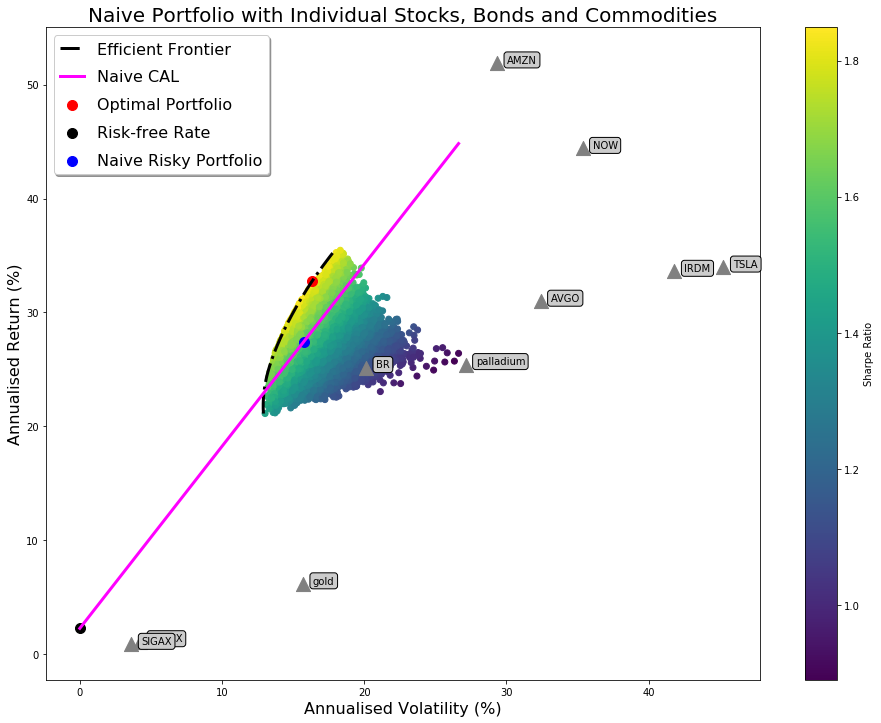

In [21]:
# Graph that includes:
#     1. the random portfolios
#     2. The efficient frontier
#     3. The optimal risky Portfolio from simulation
#     4. the risk-free portfolio
#     5. The individual instruments
#     6. the naive portfolio
#     7. the CAL of the naive portfolio

fig, ax = plt.subplots(figsize=(16, 12))

# plot (1) the random portfolios
plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
cbar = plt.colorbar(label='Sharpe Ratio')

# plot (2) The Efficient Frontier
ax.plot([p['fun'] for p in efficient_portfolios], targets, linestyle='-.',lw=3, color='black', label='Efficient Frontier')

# plot (3) the Optimal Risky Portfolio from simulation
plt.scatter(opt_vol, opt_ret,c='red', s=100, label='Optimal Portfolio') 

# plot (4) the risk-free portfolio
plt.scatter(0, rf,c='black', s=100, label='Risk-free Rate') 

# plot (5) the individual instruments
vol = returns_daily.std() * np.sqrt(252)

# plot (6) the naive portfolio
plt.scatter(volatility_naive, returns_naive,c='blue',s=100, label='Naive Risky Portfolio') 

# plot (7) the CAL of the naive portfolio
x = np.linspace(0, df_ef['Volatility'].max(), 1000)
y = x * (returns_naive-rf)/volatility_naive + rf
ax.plot(x,y, label='Naive CAL', lw=3,color='magenta')


ax.scatter(vol,returns_annual,marker='^',s=200,color='gray')
for i in range(len(assets)-1):
        ax.annotate(df.index.values[i], 
                   (vol[i],returns_annual[i]), 
                    xytext=(10,0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.8"))
    

# title, axes and legend
ax.set_title('Naive Portfolio with Individual Stocks, Bonds and Commodities', fontsize=20)
ax.set_xlabel('Annualised Volatility (%)', fontsize=16)
ax.set_ylabel('Annualised Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

The "shape" of the Efficient Frontier is not similar to the one presented in most textbooks. This can be explained by the fact that we have assets with very low risk, almost zero. These assets are, of course, the bonds. This is easily observed by the above plot. The result is an "unusual" frontier.

## Optimal Overall Portfolio

At this point we have finalized the optimal risky portfolio. The last step is to find the optimal overall portfolio, based on our level of risk-aversion, as measured by coefficient of risk-aversion A. Since we are risk-tolerant and young investors, we assume $A = 1.5$. We are searching for the optimal allocation between risk-free and risky assets:

In [22]:
A = 1.5
optimal_z = 0.95

# Optimal allocation of assets
A = (opt_ret - rf) / (0.1 * optimal_z * (opt_vol ** 2))

optimal_overall_return = rf + optimal_z * (opt_ret - rf)
optimal_overall_volatility = optimal_z * opt_vol
optimal_utility = (rf) + ((opt_ret) - (rf))*optimal_z - 0.05 * A * (optimal_z ** 2)*((opt_vol)**2) 

utility_x = np.linspace(0, 25, 1000)
utility_y = (optimal_utility + 0.05 * A * ((utility_x) ** 2))

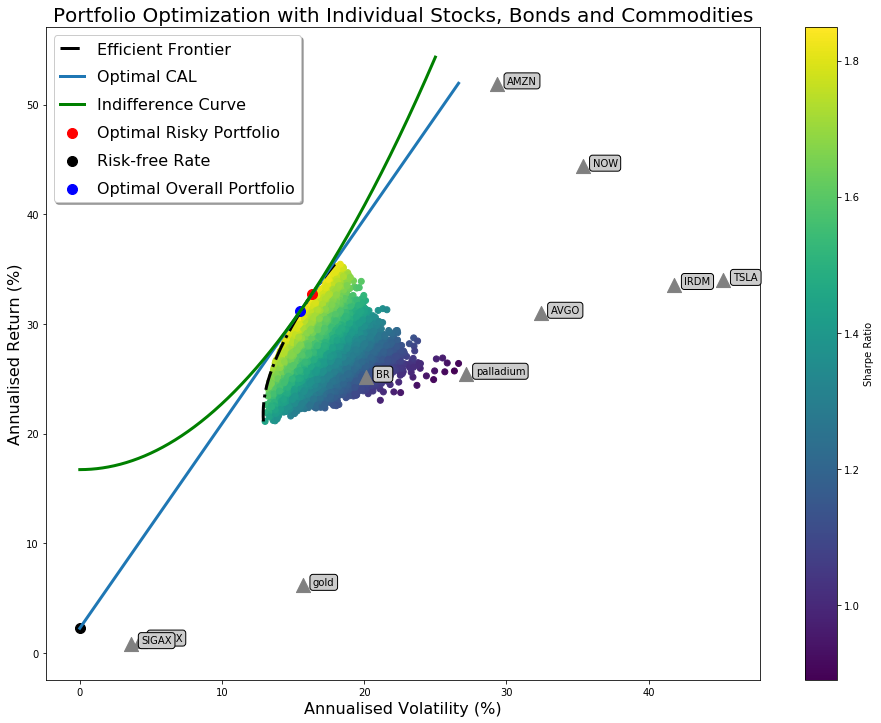

In [23]:
# Final graph that includes:
#     1. The random portfolios
#     2. The efficient frontier
#     3. The optimal risky Portfolio
#     4. The risk-free portfolio
#     5. The Optimal CAL
#     6. The individual instruments
#     7. The Indifference curve
#     8. The Optimal Overall Porfolio

fig, ax = plt.subplots(figsize=(16, 12))

# plot (1) the random portfolios
plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
cbar = plt.colorbar(label='Sharpe Ratio')

# plot (2) The Efficient Frontier
ax.plot([p['fun'] for p in efficient_portfolios], targets, linestyle='-.',lw=3, color='black', label='Efficient Frontier')

# plot (3) the Optimal Risky Portfolio
plt.scatter(opt_vol, opt_ret,c='red', s=100, label='Optimal Risky Portfolio') 

# plot (4) the risk-free portfolio
plt.scatter(0, rf,c='black', s=100, label='Risk-free Rate') 

# plot (5) the CAL
x = np.linspace(0, df_ef['Volatility'].max(), 1000)
y = x * (-optimal_sharpe_ratio['fun']) + rf
ax.plot(x,y, label='Optimal CAL', lw=3)

# plot (6) the individual instruments
vol = returns_daily.std() * np.sqrt(252)

ax.scatter(vol,returns_annual,marker='^',s=200,color='gray')
for i in range(len(assets)-1):
        ax.annotate(df.index.values[i], 
                   (vol[i],returns_annual[i]), 
                    xytext=(10,0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.8"))

# plot (7) the optimal overall portfolio
plt.scatter(optimal_overall_volatility, optimal_overall_return,c='blue',s=100, label='Optimal Overall Portfolio') 

# plot (8) the Indifference Curve
ax.plot(utility_x, utility_y, label='Indifference Curve', lw=3,color='green')
    

# title, axes and legend
ax.set_title('Portfolio Optimization with Individual Stocks, Bonds and Commodities', fontsize=20)
ax.set_xlabel('Annualised Volatility (%)', fontsize=16)
ax.set_ylabel('Annualised Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)